# Solar Panel Detection

This notebook demonstrates how to use the geoai package for solar panel detection using a pre-trained model.

[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/opengeos/geoai/blob/main/docs/examples/solar_panel_detection.ipynb)

## Install package
To use the `geoai-py` package, ensure it is installed in your environment. Uncomment the command below if needed.

In [ ]:
%pip install geoai-py
%pip install gdal
%pip install pillow

## Import libraries

In [35]:
import geoai
from osgeo import gdal
import math
import os
from PIL import Image
from math import log, tan, pi, cos

In [36]:
def latlon_to_webmercator(lat, lon):
    """Convert latitude/longitude to EPSG:3857 Web Mercator meters."""
    origin_shift = 20037508.342789244  # Half the Earth's circumference in meters
    mx = lon * origin_shift / 180.0
    my = math.log(math.tan((90 + lat) * math.pi / 360.0)) / (math.pi / 180.0)
    my = my * origin_shift / 180.0
    return mx, my

In [37]:
# ----------------------------
# Step 1: Define Inputs
# ----------------------------
input_jpg = "google_maps.jpeg"
output_tif = "georeferenced.tif"

if not os.path.exists(input_jpg):
    raise Exception(f"File not found: {input_jpg}")

# Ensure image is in RGB mode
img = Image.open(input_jpg).convert("RGB")
img.save("rgb_google_map.jpg")

input_rgb_jpg = "rgb_google_map.jpg"

# Google Maps image details
lat_center = 23.02795287  # Image center latitude
lon_center = 72.45340464  # Image center longitude
zoom = 19  # Google Maps zoom level
img_width = 1280  # Pixels
img_height = 1280  # Pixels

# Constants
EARTH_CIRCUMFERENCE = 40075016.686  # Earth's circumference in meters

def latlon_to_webmercator(lat, lon):
    """Convert latitude/longitude to EPSG:3857 Web Mercator meters."""
    x = lon * (EARTH_CIRCUMFERENCE / 360.0)
    y = log(tan((90 + lat) * pi / 360.0)) * (EARTH_CIRCUMFERENCE / (2 * pi))
    return x, y

center_x, center_y = latlon_to_webmercator(lat_center, lon_center)

# ----------------------------
# Step 2: Calculate Bounding Box (EPSG:3857)
# ----------------------------

# Google Maps resolution at zoom level 0
meters_per_pixel = 156543.03 / (2 ** zoom)

# Adjust for latitude
meters_per_pixel *= cos(math.radians(lat_center))

# Calculate bounding box in meters
width_m = meters_per_pixel * img_width
height_m = meters_per_pixel * img_height

# Compute Web Mercator bounding box
left = center_x - (width_m / 2)
right = center_x + (width_m / 2)
bottom = center_y - (height_m / 2)
top = center_y + (height_m / 2)

print(f"BoundingBox(left={left}, bottom={bottom}, right={right}, top={top})")

# ----------------------------
# Step 3: Convert JPEG to GeoTIFF (EPSG:3857)
# ----------------------------

# Open the JPG
dataset = gdal.Open(input_rgb_jpg)
print(f"Number of Bands: {dataset.RasterCount}")

# Convert to GeoTIFF
output = gdal.Translate(
    output_tif, dataset,
    format="GTiff",
    outputSRS="EPSG:3857",  # Google Maps Projection (Web Mercator)
    outputBounds=[left, top, right, bottom],  # Correct order: xmin, ymax, xmax, ymin
    outputType=gdal.GDT_Byte,  # Ensures correct data format
    bandList=[1, 2, 3]  # Ensure RGB bands are preserved
)

# Close datasets
dataset = None
output = None

print(f"✅ Converted {input_jpg} to {output_tif} with EPSG:3857")

# ----------------------------
# Step 4 (Optional): Reproject to EPSG:4326 (WGS84)
# ----------------------------

output_tif_reprojected = "georeferenced_epsg4326.tif"

gdal.Warp(output_tif_reprojected, output_tif, dstSRS="EPSG:4326")

print(f"✅ Reprojected to {output_tif_reprojected} with EPSG:4326")


BoundingBox(left=8065300.245662366, bottom=2635223.549410479, right=8065651.97603491, top=2635575.2797830226)
Number of Bands: 3
✅ Converted google_maps.jpeg to georeferenced.tif with EPSG:3857
✅ Reprojected to georeferenced_epsg4326.tif with EPSG:4326


## Download sample data

In [38]:
raster_url = "georeferenced.tif"
raster_path = geoai.download_file(raster_url)

File already exists: georeferenced.tif


===== RASTER INFORMATION: georeferenced.tif =====
Driver: GTiff
Dimensions: 1280 x 1280 pixels
Number of bands: 3
Data type: uint8
Coordinate Reference System: EPSG:3857
Georeferenced Bounds: BoundingBox(left=8065300.245662366, bottom=2635223.549410479, right=8065651.97603491, top=2635575.2797830226)
Pixel Resolution: 0.2747893535502953, 0.27478935354956774
NoData Value: None

----- Band Statistics -----
Band 1:
  Min: 0.00
  Max: 255.00
  Mean: 121.62
  Std Dev: 67.70
Band 2:
  Min: 0.00
  Max: 255.00
  Mean: 121.70
  Std Dev: 65.66
Band 3:
  Min: 0.00
  Max: 255.00
  Mean: 123.34
  Std Dev: 60.17


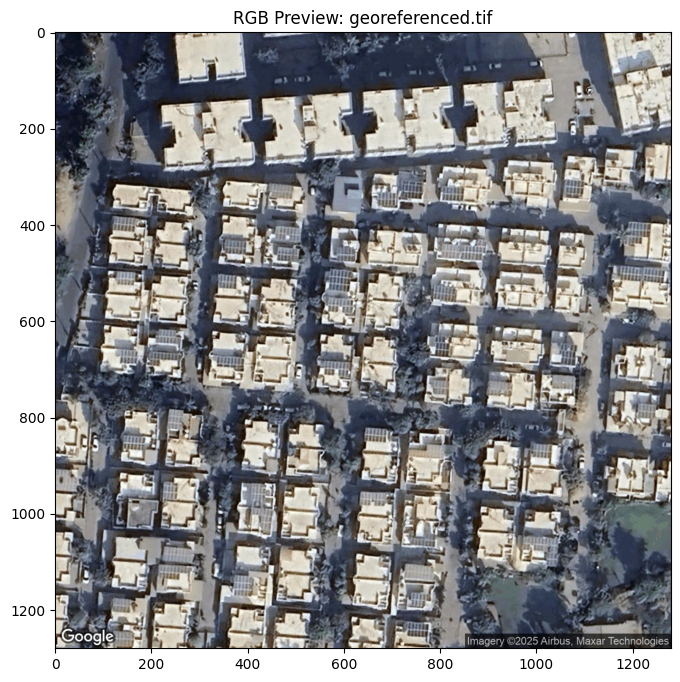

In [39]:
geoai.print_raster_info(raster_path)

## Visualize data

In [40]:
geoai.view_raster(raster_url)

## Initialize model

In [41]:
detector = geoai.SolarPanelDetector()

Model path not specified, downloading from Hugging Face...


solar_panel_detection.pth:   0%|          | 0.00/176M [00:00<?, ?B/s]

Model downloaded to: /root/.cache/huggingface/hub/models--giswqs--geoai/snapshots/75788bf6253e967a91b9576b1620949a3b939820/solar_panel_detection.pth
Model loaded successfully


## Generate masks

In [42]:
output_path = "solar_panel_masks.tif"

In [43]:
masks_path = detector.generate_masks(
    raster_path,
    output_path=output_path,
    confidence_threshold=0.4,
    mask_threshold=0.5,
    min_object_area=100,
    overlap=0.25,
    chip_size=(400, 400),
    batch_size=4,
    verbose=True,
)

Dataset initialized with 5 rows and 5 columns of chips
Image dimensions: 1280 x 1280 pixels
Chip size: 400 x 400 pixels
Overlap: 25.0% (stride_x=300, stride_y=300)
CRS: EPSG:3857
Processing raster with 7 batches


100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

Masks with confidence values saved to solar_panel_masks.tif


## Visualize masks

In [44]:
geoai.view_raster(
    output_path,
    indexes=[2],
    colormap="autumn",
    layer_name="Solar Panels",
    basemap=raster_url,
)

## Vectorize masks

In [ ]:
gdf = geoai.orthogonalize(
    input_path=masks_path, output_path="solar_panel_masks.geojson", epsilon=0.2
)

Processing 1 features...


Converting features: 100%|██████████| 1/1 [00:00<00:00, 4999.17shape/s]


ValueError: Assigning CRS to a GeoDataFrame without a geometry column is not supported. Supply geometry using the 'geometry=' keyword argument, or by providing a DataFrame with column name 'geometry'

## Visualize initial results

In [ ]:
geoai.view_vector_interactive(gdf, tiles=raster_url)

NameError: name 'gdf' is not defined

## Calculate geometric properties

In [ ]:
gdf = geoai.add_geometric_properties(gdf)
gdf.head()

In [ ]:
print(len(gdf))

In [ ]:
geoai.view_vector_interactive(gdf, column="elongation", tiles=raster_url)

## Filter results

In [ ]:
gdf_filter = gdf[(gdf["elongation"] < 10) & (gdf["area_m2"] > 5)]
print(len(gdf_filter))

## Visualize final results

In [ ]:
geoai.view_vector_interactive(gdf_filter, column="area_m2", tiles=raster_url)

In [ ]:
geoai.view_vector_interactive(
    gdf_filter, style_kwds={"color": "red", "fillOpacity": 0}, tiles=raster_url
)

In [ ]:
gdf_filter["area_m2"].hist()

In [ ]:
gdf_filter["area_m2"].describe()

In [ ]:
gdf_filter["area_m2"].sum()

## Save results

In [ ]:
gdf_filter.to_file("solar_panels.geojson")

![image](https://github.com/user-attachments/assets/a38925dc-b840-42b0-a926-326ef99b181c)